## Alexander Shumilov, IST, 2019

# Problem set 2 (145 pts)

## Problem 1 (LU decomposition) 25 pts

### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

#### Ideas and comments
As I understand, we shoul work only with 3-diagonal and 5-diagonal matrices, so the programm will consist of 2 parts - for 3 and 5 diagonal case respectively. Convenience - we can store less elements since matrix is sparse. 
General overview and algorithm for 3-diagonal is nicely written here: https://www.webpages.uidaho.edu/~barannyk/Teaching/LU_factorization_tridiagonal.pdf (misprint in L matrix at the very beginning), so I think I don't need to explain in details (using a lot of LaTex) how exactly I got formulas I am using.
<br>
Let's look at the 3-diagonal matrix as a toy example to understand the structure (I use indexing of $l, u$ corresponding to the task):
<br>

$
\begin{bmatrix}
a_{11} & a_{12} & 0\\
a_{21} & a_{11} & a_{12} \\
0 & a_{21} & a_{11}
\end{bmatrix} = 
\begin{bmatrix}
1 & 0 & 0\\
l_{1} & 1 & 0 \\
0 & l_{2} & 1
\end{bmatrix} \cdot
\begin{bmatrix}
u_{11} & u_{12} & 0 \\
0 & u_{21} & u_{13} \\
0 & 0 & u_{31}
\end{bmatrix} =
\begin{bmatrix}
u_{11} & u_{12} & 0\\
l_{1}u_{11} & l_{1}u_{12}+u_{21} & u_{13} \\
0 & l_{2}u_{21} & l_{2}u_{13}+u_{31}
\end{bmatrix} \\
$

<br>

For 5-diagonal it is a bit more compicated, here I found all information we need to solve the task (maybe even more):
https://arxiv.org/pdf/1409.4802.pdf

In [261]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np
from math import isinf
from scipy.linalg import lu

# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n):
    flag = 1 # To raise proper exception
    if (len(diag_broadcast) == 3):
        flag = 0
        L = np.zeros(n-1)
        U = np.zeros((n, 2))
        a_11 = diag_broadcast[1] # Main diagonal
        a_21 = diag_broadcast[0] # Lower
        a_12 = diag_broadcast[2] # Upper
        
        U[0][0] = a_11 # What we are know from the start, kind of initial conditions for cycle below
        U[0: n-1,1] = a_12
        
        for i in range(1, n): 
            if isinf(1/U[i-1][0]) : raise Exception("Division by 0") # Exception for division by 0
            L[i-1] = a_21/U[i-1][0]
            U[i][0] = a_11 - a_12*L[i-1]  
        L = L.reshape(1, n-1)
        
    if (len(diag_broadcast) == 5):
        flag = 0
        #L = np.zeros((n-1, 2))
        L = np.zeros((2, n-1))
        U = np.zeros((n, 3))
        a_11 = diag_broadcast[2] # Main diagonal
        a_12 = diag_broadcast[3] # Upper
        a_13 = diag_broadcast[4] # Upper-Right
        a_21 = diag_broadcast[1] # Lower
        a_32 = diag_broadcast[0] # Lower-Left
        
        U[0][0] = a_11
        U[0][1] = a_12
        U[0: n-2,2] = a_13
        
        for i in range(1, n):
            if isinf(1/U[i-1][0]) : raise Exception("Division by 0 during elimination process, LU does not exist") # Exception for division by 0
            L[0][i-1] = (a_21 - U[i-2][1]*L[1][i-2] )/U[i-1][0]
            L[1][i-1] = a_32/U[i-1][0]
            U[i][0] = a_11 - U[i-1][1]*L[0][i-1] - U[i-2][2]*L[1][i-2] 
            U[i][1] = a_12 - U[i-1][2]*L[0][i-1] 
            if i >= n - 1:
                U[i][1] = 0 # Filling extra entries with zeros
                L[1][i-1] = 0
       
    if flag: raise Exception("Division by 0 during elimination process, LU does not exist")
    return L, U
    raise NotImplementedError() 

To reconstruct the matrix from diag_broadcast I will use "diags" function:

In [262]:
#d = [4, -2, 1, 9, 7]
d = [5, 6, 7]
n = 10000

if (len(d) == 3):
    diagonals = [[d[2] for i in range(n-1)], [d[1] for i in range(n)], [d[0] for i in range(n-1)]]
    A = diags(diagonals, [1, 0, -1]).toarray()
if (len(d) == 5):
    diagonals = [[d[4] for i in range(n-2)], [d[3] for i in range(n-1)], [d[2] for i in range(n)], [d[1] for i in range(n-1)], [d[0] for i in range(n-2)]]
    A = diags(diagonals, [2, 1, 0, -1, -2]).toarray()

Self-check

In [263]:
# Let's check whether we are doing it right - everything works!
n = 3
d = [1, 3, 1] # for this diagonal everything will work fine (lu from scipy will have exactly "band" form)
#d = [1, 3, 5, 3, 1]

if (len(d) == 3):
    diagonals = [[d[2] for i in range(n-1)], [d[1] for i in range(n)], [d[0] for i in range(n-1)]]
    A = diags(diagonals, [1, 0, -1]).toarray()
if (len(d) == 5):
    diagonals = [[d[4] for i in range(n-2)], [d[3] for i in range(n-1)], [d[2] for i in range(n)], [d[1] for i in range(n-1)], [d[0] for i in range(n-2)]]
    A = diags(diagonals, [2, 1, 0, -1, -2]).toarray()

print('Oroginal martix')
print(A,'\n')
_, l, u = lu(A)
print('Scipy L:\n', l, '\n', 'Scipy U:\n', u, '\n')
L, U = band_lu(d, n)
print('Our L-array:\n', L, '\n', 'Our U-band:\n', U)

Oroginal martix
[[3. 1. 0.]
 [1. 3. 1.]
 [0. 1. 3.]] 

Scipy L:
 [[1.         0.         0.        ]
 [0.33333333 1.         0.        ]
 [0.         0.375      1.        ]] 
 Scipy U:
 [[3.         1.         0.        ]
 [0.         2.66666667 1.        ]
 [0.         0.         2.625     ]] 

Our L-array:
 [[0.33333333 0.375     ]] 
 Our U-band:
 [[3.         1.        ]
 [2.66666667 1.        ]
 [2.625      0.        ]]


Profiling using timeit:

In [267]:
import timeit # Based on example from timeit manual from docs.python.org
print("Time for band_lu for 1000 iterations = ", timeit.timeit("band_lu(d,n)", setup="from __main__ import band_lu, d, n", number=1000), "s")
print("Time for lu for 1000 iterations = ", timeit.timeit("lu(A)", setup="from __main__ import lu, A", number=1000), "s")


Time for band_lu for 100 iterations =  0.007822799998393748 s
Time for lu for 100 iterations =  0.010640699998475611 s


As it was expected scipy is significantly slower, because it does not treat initial matrix as sparse and has to store more information and perform more operations. Our band method is much more usefull in this case for exactly same reasons (because, as we have also discussed on lectures, computational cost is more determined by the total number of non-zero elements of initial matrix).

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

### Solution
#### 1.
<br>
a) We can do pivoting, i.e. permute rows (as we discussed on lectures) in order to maximize $A_{ii}$ that we divide over. So we should get decomposition in form $PLA$, were $P$ - permutation matrix. So the first step - to switch $1^{st}$ and $2^{nd}$ row.
<br>
$
\begin{bmatrix}
\varepsilon & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 1
\end{bmatrix} \rightarrow
\begin{bmatrix}
1 & 1 & 1 \\
\varepsilon & 1 & 0 \\
0 & 1 & 1
\end{bmatrix} \Rightarrow
P = 
\begin{bmatrix}
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1
\end{bmatrix} - \text{Our permutation matrix} \rightarrow
A = PLU \Rightarrow P^{-1}A = LU \\
P^{-1} = \frac{1}{\det P} P^T_{adj} = P \Rightarrow
\begin{bmatrix}
1 & 1 & 1 \\
\varepsilon & 1 & 0 \\
0 & 1 & 1
\end{bmatrix} =
\bigg\\
\text{we will substract second row multiplied by } \varepsilon \text{ from third row: }  
\bigg\\ =
\begin{bmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 1 & 1
\end{bmatrix} = 
\bigg\\
\text{we will substract third row multiplied by } \cfrac{1}{1-\varepsilon} \text{ from second row: }  
\bigg\\ =
\begin{bmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 0 & 1+\frac{\varepsilon}{1-\varepsilon}
\end{bmatrix} =
\begin{bmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon & -\varepsilon \\
0 & 0 & \frac{1}{1-\varepsilon}
\end{bmatrix} \Rightarrow \\ 
$
Now we can obtain such $L$ that $A = PLU$:
$
A =
P
\begin{bmatrix}
1 & 0 & 0\\
\varepsilon & 1 & 0 \\
0 & \frac{1}{1-\varepsilon} & 1
\end{bmatrix} \cdot
\begin{bmatrix}
1 & 1 & 1\\
0 & 1-\varepsilon& -\varepsilon  \\
0 & 0 &  \frac{1}{1-\varepsilon}
\end{bmatrix}
$
<br>
b) Without pivoting we will find exact elements of $L$ and $U$ matrices using simple elimination (considering $L$ with $1$ on the diagonal as we did on lectures):
<br>
$
\begin{bmatrix}
\varepsilon & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 1
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & 0\\
l_{21} & 1 & 0 \\
l_{31} & l_{32} & 1
\end{bmatrix} \cdot
\begin{bmatrix}
u_{11} & u_{12} & u_{13} \\
0 & u_{22} & u_{23} \\
0 & 0 & u_{33}
\end{bmatrix} =
\begin{bmatrix}
u_{11} & u_{12} & u_{13}\\
l_{21}u_{11} & l_{21}u_{12}+u_{22} & l_{21}u_{13}+u_{23} \\
l_{31}u_{11} & l_{31}u_{12}+l_{32}u_{22} & l_{31}u_{13}+l_{32}u_{23}+u_{33}
\end{bmatrix} \Rightarrow
\begin{cases}
  u_{11} = \varepsilon \rightarrow l_{21} = \frac{1}{u_{11}} = \frac{1}{\varepsilon} \\
  u_{12} = 1 \rightarrow u_{22} = 1 - 1 \cdot \frac{1}{\varepsilon} = \frac{\varepsilon - 1}{\varepsilon} \\
  u_{13} = 0 \rightarrow u_{23} = 1 - 0 \cdot \frac{1}{\varepsilon} = 1 \\
\end{cases} \Rightarrow
\begin{cases}
  l_{31} = \frac{0}{\varepsilon} = 0 \\
  l_{32} = (1 - 0) : \frac{\varepsilon - 1}{\varepsilon} = \frac{\varepsilon}{\varepsilon - 1} \\
  u_{33} = 1- 0 - \frac{\varepsilon - 1}{\varepsilon} \cdot 1 = \frac{1}{1 - \varepsilon} \\
\end{cases} \Rightarrow
\begin{bmatrix}
\varepsilon & 1 & 0 \\
1 & 1 & 1 \\
0 & 1 & 1
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & 0\\
\frac{1}{\varepsilon} & 1 & 0 \\
0 & \frac{\varepsilon}{\varepsilon - 1} & 1
\end{bmatrix} \cdot
\begin{bmatrix}
\varepsilon & 1 & 0 \\
0 & \frac{\varepsilon - 1}{\varepsilon} & 1 \\
0 & 0 & \frac{1}{1 - \varepsilon} 
\end{bmatrix}
$
<br>

#### 2.
As we discussed on lectures, it happens because of the details of division operation. Let's take a closer look at the problem without pivoting: here we perform such operations as $\frac{1}{\varepsilon},\frac{\varepsilon}{{\varepsilon}^2},\frac{\varepsilon-1}{\varepsilon}, \ldots$ to compute $u_{ij}, l_{ij}$ (assuming $\varepsilon$, for example $10^{-12}$). Computing such numbers, we multiply by a large value and getting large error. That is why $LU$ decomposition fails. 

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

### Solutions
#### 1. 
$
\begin{bmatrix} 
A_{11} & A_{12} \\ 
A_{21} & A_{22} 
\end{bmatrix} =
\begin{bmatrix} 
L_{11} & 0 \\ 
L_{21} & L_{22} 
\end{bmatrix} \cdot
\begin{bmatrix} 
U_{11} & U_{12} \\ 
0 & U_{22} 
\end{bmatrix} = 
\begin{bmatrix} 
L_{11}U_{11} & L_{11}U_{12} \\ 
L_{21}U_{11} & L_{21}U_{12} + L_{22}U_{22} 
\end{bmatrix} \Rightarrow
\begin{cases}
  A_{11} = L_{11}U_{11} \Rightarrow U_{11} = L_{11}^{-1}A_{11} \\
  A_{12} = L_{11}U_{12} \Rightarrow U_{12} = L_{11}^{-1}A_{12} \\
\end{cases} \Rightarrow
\begin{cases}
  A_{21} = L_{21}U_{11} \Rightarrow L_{21} = A_{21}U_{11}^{-1} = A_{21}A_{11}^{-1}L_{11} \\
  L_{22}U_{22}  = A_{22} - L_{21}U_{12} = A_{22} - A_{21}{A_{11}}^{-1}L_{11}L_{11}^{-1}A_{12} = 
  A_{22} - A_{21}A_{11}^{-1}A_{12}\\
\end{cases} \\ 
\text{Let } S = L_{22}U_{22} = A_{22} - A_{21}A_{11}^{-1}A_{12} \rightarrow
\hat{f_2} = Su_2 = (A_{22} - A_{21}A_{11}^{-1}A_{12})u_2 = 
A_{22}u_2 - A_{21}A_{11}^{-1}A_{12}u_2 = 
\bigg\\ 
\begin{bmatrix} 
A_{11} & A_{12} \\ 
A_{21} & A_{22} 
\end{bmatrix}
\begin{bmatrix} 
u_1 \\ 
u_2 
\end{bmatrix} = 
\begin{bmatrix}
f_1 \\ 
f_2 
\end{bmatrix}
\bigg\\ =
f_2 - A_{21}u_1 - A_{21}A_{11}^{-1}(f_1 - A_{11}u_1) =
f_1 - A_{11}u_1 - A_{21}A_{11}^{-1}f_2 - A_{21}A_{11}^{-1}A_{11}u_1 = 
f_2 - A_{21}A_{11}^{-1}f_1 \Rightarrow \\
\text{Answer:  }
\begin{cases}
  S = A_{22} - A_{21}A_{11}^{-1}A_{12} \\
  \hat{f_2} = f_2 - A_{21}A_{11}^{-1}f_1
\end{cases} \\ 
$
<br>
#### 2. 
Here we should construct such matrix $C$ that will fullfill given condition. So be it. From $S = A_{22} - A_{21}A_{11}^{-1}A_{12} = I+BX^{-1}A$ (also because we know what determinant we should get) we will obtain our matrix $C$:
<br>

$
C = 
\begin{bmatrix} 
X & A \\ 
-B & I 
\end{bmatrix} =
\begin{bmatrix} 
X & 0 \\ 
0 & I 
\end{bmatrix} 
\begin{bmatrix} 
I & X^{-1}A \\ 
-B & I 
\end{bmatrix} = 
\begin{bmatrix} 
X & 0 \\ 
0 & I 
\end{bmatrix} 
\begin{bmatrix} 
I & 0 \\ 
-B & I 
\end{bmatrix} 
\begin{bmatrix} 
I & X^{-1}A \\ 
0 & I-(-B)X^{-1}A
\end{bmatrix} \Rightarrow \\
\det C = \det (X + AB) = \det X \cdot \det I \cdot \det (I + BX^{-1}A) = \det X \cdot \det (I + BX^{-1}A)
$
<br>

#### 3. 
Standard proof:

Let $FGx=\lambda x$, where $\lambda$ - eigenvalue of matrix $FG$, $x$ - corresponding eigenvector. Thus: <br>
$G(FG)x = \lambda Gx = (GF)Vx \Rightarrow \lambda$ - eigenvalue and $Gx$ - eigenvector $\lambda$ of $GF$. 

Moreover if $Gx = 0$ then from  $FGx = λx$ we get $\lambda = 0 \Rightarrow$ We assume $Gx \neq 0 \Rightarrow$  $\lambda$ is either same eigenvalue of both $FG, GF$ or is $0$ (because $\lambda$ in the RHS will be the same whether we multiplying by $F$ or $G$, which also leads to the conservation of the multiplicity of eigenvalues). 

So the spectrum of $FG$ and $GF$ is the same - one set of eigenvalues and $0 \Rightarrow \det(I_m - FG) = \det(I_n - GF)$, since roots of characteristic polynomials will be exactly the same.

Usefull source: http://www.cari-info.org/cari-2012/session%203/3A2.pdf

But since in this particular set of problems we work with Schur, this statement can be proved in the similar way:
<br>
$
C = 
\begin{bmatrix} 
I_m & F \\ 
G & I_n 
\end{bmatrix} =
\begin{bmatrix} 
I_m & 0 \\ 
0 & I_n 
\end{bmatrix} 
\begin{bmatrix} 
I_m & I^{-1}_m F \\ 
G & I_n 
\end{bmatrix} = 
\begin{bmatrix} 
I_m & 0 \\ 
0 & I_n 
\end{bmatrix} 
\begin{bmatrix} 
I_m & 0 \\ 
G & I_n 
\end{bmatrix} 
\begin{bmatrix} 
I_m & I^{-1}_m F \\ 
0 & I_n - G I^{-1}_m F
\end{bmatrix} \Rightarrow \\
\det C = \det (I_m - FG) = \det I_m \cdot \det I_n \cdot \det (I_n - GI^{-1}_m F) = \det (I_n - GF)
$

## Problem 2 (QR decomposition) 30 pts

### 1. Standard Gram-Schmidt algorithm (18 pts)
Our goal is to orthogonalize a system of linearly independent vectors $v_1,\dots,v_n$.
The standard algorithm for this task is the Gram-Schmidt process:

$$
\begin{split}
u_1 &= v_1, \\
u_2 &= v_2 - \frac{(v_2, u_1)}{(u_1, u_1)} u_1, \\
\dots \\
u_n &= v_n - \frac{(v_n, u_1)}{(u_1, u_1)} u_1 - \frac{(v_n, u_2)}{(u_2, u_2)} u_2 - \dots - \frac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1}.
\end{split}
$$

Obtained $u_1, \dots, u_n$ are orthogonal vectors in exact arithmetics. Then to make the system orthonormal you should divide each of the vectors by its norm: $u_i := u_i/\|u_i\|$.
The Gram-Schmidt process can be considered as a QR decomposition. Let us show that.

* (2 pts) Write out what is matrices $Q$ and $R$ obtained in the process above. 

* (5 pts) Implement the described Gram-Schmidt algorithm as a function ```gram_schmidt_qr(A)``` that takes a rectangular matrix ```A``` and outputs ```Q,R```.

* (3 pts) Create a rectangular matrix $K = [x, Ax, A^2x, \ldots, A^kx]$ where $A \in \mathbb{R}^{100 \times 100}$ is a random matrix and $x$ is a random vector of the appropriate dimension, $k = 20$.  
The loss of orthogonality can be described by the following error: $\|Q^{\top}Q-I\|_2$, where $Q^{\top}Q$ is called a Gram matrix. Compute QR decomposition of the created matrix $K$ with function that you have implemented and calculate error $\|Q^{\top}Q-I\|_2$. Comment on the result.

* (5 pts) The observed loss of orthogonality is a problem of this particular algorithm. Luckily, there is [a simple improvement to the algorithm above](https://en.wikipedia.org/wiki/Gram–Schmidt_process#Numerical_stability) that reduces the loss of orthogonality. Implement this modification as a function ```modified_gram_schmidt_qr(A)``` such that input and output are similar to ```gram_schmidt_qr(A)```. 
* (3 pts) Compute QR decomposition of the matrix $K$ from the previous task with the function ```modified_gram_schmidt_qr(A)```.
Compute error $\|Q^{\top}Q-I\|_2$. Compare this error to the error obtained with a "pure" Gram-Schmidt and comment on the result.

Let $ e_i = \cfrac{u_i}{\|u_i\|_2} =  \cfrac{u_i}{\sqrt{(u_i, u_i)}}\Rightarrow \\
u_n = v_n - \cfrac{(v_n, u_1)}{(u_1, u_1)} u_1 - \cfrac{(v_n, u_2)}{(u_2, u_2)} u_2 - \ldots - \cfrac{(v_n, u_{n-1})}{(u_{n-1}, u_{n-1})} u_{n-1} =
v_n - \cfrac{(v_n, u_1)}{\|u_1\|^2} u_1 - \cfrac{(v_n, u_2)}{\|u_2\|^2} u_2 - \ldots - \cfrac{(v_n, u_{n-1})}{\|u_{n-1}\|^2} u_{n-1} =
v_n - \bigg(v_n, \cfrac{u_1}{\|u_1\|}\bigg)\cfrac{u_1}{\|u_1\|} - \bigg(v_n, \cfrac{u_2}{\|u_2\|}\bigg)\cfrac{u_2}{\|u_2\|} - \ldots - \bigg(v_n, \cfrac{u_{n-1}}{\|u_{n-1}\|}\bigg)\cfrac{u_{n-1}}{\|u_{n-1}\|} =
v_n - (v_n, e_1) e_1 - (v_n, e_2) e_2 - \ldots - (v_n, e_{n-1})e_{n-1} \Rightarrow \\
A = QR = 
\begin{bmatrix} 
e_1 & e_2 & \ldots & e_n \\  
\end{bmatrix} 
\begin{bmatrix}
(v_1, e_1) & (v_2, e_1) & (v_3, e_1) & \dots  & (v_n, e_1) \\
0 & (v_2, e_2) & (v_3, e_2) & \dots  & (v_n, e_2) \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \dots & (v_n, e_n)
\end{bmatrix}
\text{ , where $Q$ - unitary, $R$ - upper-triangular. }
$ 

In [5]:
# INPUT : rectangular matrix A
# OUTPUT: matrices Q - orthogonal and R - upper triangular such that A = QR
def gram_schmidt_qr(A): # 5 pts
    
    Q = np.zeros((A.shape[0], A.shape[1]))
    R = np.zeros((A.shape[1], A.shape[1]))
    
    for i in range(A.shape[1]): # I assume we can vectorize GS process, but using loops is not prohibited by this particular task
        v_i = A[:, i] # Extracting i-column of a into variable v
        u_n = v_i # Starting point - first term of u_n
        for j in range(i):   
            # Calculating u_n (u_n is introduced in the algorithm => calculation is straightforward) 
            u_n = u_n - np.dot(np.dot(R[i, j], Q[:, j])/np.linalg.norm((Q[:, j], Q[:, j]), ord = 2),Q[:, j])
        Q[:, i] = u_n / np.linalg.norm(u_n) # Normalize and iterate further 
        for k in range(i+1):
            R[k, i] = np.dot(Q[:, k], A[:, i]) # Filling elements of R above the main diagonal
        
    return Q, R

# INPUT : rectangular matrix A
# OUTPUT: matrices Q - orthogonal and R - upper triangular such that A = QR
def modified_gram_schmidt_qr(A): # 5 pts
    
    Q = A.copy()
    R = np.zeros((A.shape[1], A.shape[1]))
    
    for i in range(A.shape[1]): # I assume we can vectorize GS process, but using loops is not prohibited by this particular task
        R[i, i] = np.linalg.norm(Q[:, i]) # Diagonal elements of upper-triangular matrix R 
        Q[:, i] = Q[:, i] / R[i, i] # Normalize
        for j in range(i + 1, A.shape[1]):
            R[i, j] = np.dot(Q[:, j], Q[:, i]) # Filling elements of R above the main diagonal              
            Q[:, j] = Q[:, j] - np.dot(R[i, j], Q[:, i]) # Calculating projections and new u_n 

    return Q, R


In [6]:
# Building matrix K using various numpy functions (to compute power of A, transpose
# and reorganize the matrix from shape [1, dim, k + 1] to [dim, k + 1])
def build_K(dim = 100, k = 20, seed = 1):
    
    np.random.seed(seed)
    A = np.random.rand(dim, dim)
    x = np.random.rand(dim, 1)
    
    return np.transpose(np.array([np.dot(np.linalg.matrix_power(A, i), x) for i in range(k + 1)])).reshape(dim, k + 1)

In [7]:
# Computing QR and the error of naive QR

Q, R = gram_schmidt_qr(build_K())

Error_naive_qr =np.linalg.norm(np.dot(np.transpose(Q),Q) - np.eye(Q.shape[1]), ord = 2)
print('Error of naive QR: ', Error_naive_qr)

Error of naive QR:  19.791176702001238


As it was expected, the error is far from 0, as it should (QR from scipy gives error ~$10^{-15}$). So here we clearly observe that matrix Q is actually not ortogonal (I assume the sourse of error is common thing in such computations - inaccurate rounding during computations). 

In [8]:
# Computing QR and the error of modified QR

Q, R = modified_gram_schmidt_qr(build_K())

Error_modified_qr =np.linalg.norm(np.dot(np.transpose(Q),Q) - np.eye(Q.shape[1]), ord = 2)
print('Error of modified QR: ', Error_modified_qr)

Error of modified QR:  0.8944596616047884


Error is much smaller (and closer to 0), thus ortogonality was improved by using slightly different technique. Error in QR via classical G-S error is adding up (so numerically it is unstable). Modified version ariphmetics basically is the same, but the error does not accumulate in iteration process: on each step of the modified algorithm we find vector $u$ ortogonal to the previous one, so the error will be ortogonal to the error of previous iteration.


Useful sourses - Strand, Untroduction to linear algebra (~240 p): https://vk.com/doc44301783_500651223?hash=1e16e8fcc2d17062eb&dl=39be4a789e272ffae2, 

http://webhome.auburn.edu/~hzv0008/teaching/MATH5640/mgs.pdf

### 2. Updating QR decompositions (12 pts)

Suppose we are dealing with overdetermined system:

$$ Ax = y, \;\; A \in \mathbb{R}^{m \times n}, \;\;  m \geq n. $$

If you were attentive during the course, you should be aware of 
the canonical way to solve this system. 

- No, implementing **Householder $QR$** will not be your task :)

- We assume that $QR$ decomposition of $A$ **is given**:

$$ QR = A = \begin{bmatrix}a_1 & a_2 & \ldots & a_n \end{bmatrix}, \;\; a_i \in \mathbb{R}^m,$$

where $Q \in \mathbb{R}^{m \times m}$ is unitary matrix and $R \in \mathbb{R}^{m \times n}$ is upper triangular.

- Let $k$ be an arbitrary column index, $1 \leq k \leq n$, and $z \in \mathbb{R}^{m}$ be an arbitrary vector.

We are interested in matrices:

$$ \tilde{A} = \begin{bmatrix}a_1 & \ldots & a_{k-1} & a_{k+1} & \ldots a_n \end{bmatrix} \in \mathbb{R}^{m \times (n-1)},$$

and:

$$ \hat{A} = \begin{bmatrix}a_1 & \ldots & a_{k} & z & a_{k+1} & \ldots a_n \end{bmatrix} \in \mathbb{R}^{m \times (n+1)},$$

which are obtained by deleting / inserting one column from / to the matrix $A$.

For example, if $A$ comes from a least-squares problem, such matrices appear if one wants to examine the significance of the $k^{th}$ parameter in the underlying model (e.g. think in terms of linear regression).

- We want to compute decompostions of these updated matrices:

$$ \tilde{A} = \tilde{Q}\tilde{R}, \;\; \hat{A} = \hat{Q}\hat{R}. $$

Performing full orthogonalization process will be redundant. Instead, the known $QR$ factors of $A$ should be **updated** in a proper way.

- Different methods for performing $QR$ decomposition were studied during the course. We expect the factors of updated matrices can be recovered with a small number of selective updates, hence the **Givens rotations** seem to be the most appropriate.

- Recall the Givens rotation matrix :

$$G_{ij}(\theta) = \begin{bmatrix} 
1      & \ldots & 0      & \ldots & 0      & \ldots & 0      \\
\vdots & \ddots & \vdots &        & \vdots &        & \vdots \\
0      & \ldots & c      & \ldots & s      & \ldots & 0      \\
\vdots &        & \vdots & \ddots & \vdots &        & \vdots \\
0      & \ldots & -s     & \ldots & c      & \ldots & 0      \\
\vdots &        & \vdots &        & \vdots & \ddots & \vdots \\
0      & \ldots & 0      & \ldots & 0      & \ldots & 1      
\end{bmatrix}  \;\; \in \mathbb{R}^{m \times m}, \;\; c = \cos \theta, \;\; s = \sin \theta,$$ 

which differs from the identity $\mathrm{I}^{m \times m}$ by a $2 \times 2$ sub-matrix:

$$
{G}(\theta) = \begin{bmatrix} c & s \\ -s & c \end{bmatrix} \in \mathbb{R}^{2 \times 2},
$$
placed on the rows and columns with indices $i$ and $j$. 

1. (1 pts)
Matrix ${G}$ has clear geometric interpretation in 2 dimensions. Let  $a = \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} \in \mathbb{R}^2$ be an arbitrary non-zero vector. According to the template provided below, implement the function to construct matrix $G$, such that:

$$ {G}^T \begin{pmatrix} a_1 \\ a_2 \end{pmatrix} = \begin{pmatrix} \alpha \\ 0 \end{pmatrix}.$$

What are geometrical meanings of $\alpha$ and $\theta$? 


#### Solution
1.
- $\alpha$ - length of vector $(a_1, a_2)$ (from given system for example we can see that $\alpha^2 = a_1^2c + a_2^2s - 2a_1a_2cs= \big\\ a_1 = -a_2\frac{c}{s} \big\\ = a_1^2 + a_2^2$)

- $\theta$ represents the angle (in radian) of rotation (counterclockwise, to be more specific) of vector $a$ in $\mathbb{R}^2$ plane.

In [9]:
def givens(a):
    '''
    Input: 
        a: np.array of size (2)
    Output: 
        G: np.array of size (2, 2)
            Rotation matrix, G^T eliminates the second component of a
    '''

    # Your code is here
    
    G = np.zeros((2, 2)) # Derivation of this formulas is trivial
    G[0, 0] = a[0]/np.sqrt(a[0]*a[0] + a[1]*a[1])
    G[1, 1] = G[0, 0]
    G[0, 1] = -a[1]/np.sqrt(a[0]*a[0] + a[1]*a[1])
    G[1, 0] = - G[0, 1]

    return G
    raise NotImplementedError()
    
# Check yourself 
a = np.random.rand(2)
givens(a).T.dot(a) # It works

array([ 1.18317283e+00, -1.14429398e-17])

- Similarly, matrix $G_{ij}$ can be constructed in order to eliminate the $j^{th}$ component of an arbitrary vector of size $m$. This leads to the well-known **Givens $QR$ algorithm** (see lecture notes!).

- Givens rotations typically appear in matrix form:

$$ G_{ij}^T X, \;\; X^{'}G_{ij},$$

where $X$ and $X^{'}$ are some matrices with compatible sizes, e.g. intermediate factors in the **Givens $QR$ algorithm**. 

How to perform these multiplications efficiently? 
Obviously, $G_{ij}$ does not need to be stored in explicit form. It affects only two rows / columns, hence only appropriate submatrices should be modified.

2. (5 pts) Your second task is to propose an efficient procedure for computing $\tilde{Q}, \tilde{R}$ factors of $\tilde{A}$ by a proper update of $Q, R$ factors of $A$. 

Hint: consider the following block partition of $R$ (assuming $k^{th}$ column deleted):
$$ R = 
\begin{bmatrix} 
R_{11} & v & R_{13} \\
0 & r_{kk} & \omega^T \\
0 & 0 & R^{33}
\end{bmatrix},
$$
and note, that:
$$Q^T\tilde{A} = 
\begin{bmatrix}
R_{11} & R_{13} \\
0 & \omega^T \\
0 & R_{33}
\end{bmatrix} = H.$$

- (2 pts) What structure has matrix $H$ and how does it help in understanding the proper way to compute updated QR decomposition?

- (3 pts) Implement the function according to the template provided below.
Use Givens matrices $G_{ij}$ with $j = i+1$ for the convinience.

- Only one loop over non-zero subdiagonal elements of $H$ is allowed. You are supposed to perform computations in a proper vectorized form. For example, the *in-place* multiplication $G_{ij}^T X$ with a random matrix $X \in \mathbb{R}^{m \times n}$ can be implemented as follows: ```X[[i,j],:] = G.T.dot(X[[i,j],:])```. 

- Do not modify elements which are known to be zero.


Matrix H has zero elements below the first subdiagonal (so it was square matrix, I'll call it Hessenberg matrix) - so called trapezoidal form (it contains only 0 elements below the sub-diagonal). So via Givens rotations we can make subdiagonal elements 0 in order to get upper-triangular form, like we did in previous task.

Useful source:(http://eprints.ma.man.ac.uk/1192/1/qrupdating_12nov08.pdf) provides an algorithm for updating writed in pseudocode. However there are some little misprints (and also our task vary a bit), so I modified formulas.

In [114]:
def delete_column_QR(A, k):
    '''
    Input: 
        A: np.array of size (m, n) 
            
        k: positive integer
            Index of deleted column, 0 \leq k \leq n - 1
        
    Output: 
        Q: np.array of size (m, m)
        
        R: np.array of size (m, n - 1)

    '''
    Q, R = np.linalg.qr(A, mode='complete') # factors of $A$ are known
    R = np.delete(R, k, axis = 1) # delete column
        
    # Your code is here
    m = A.shape[0]
    n = A.shape[1]
    for j in range(k, n-1): # 1 cycle
        G = givens([R[j, j], R[j + 1, j]])# Using already created function givens
        #print(G[0, 0], G[0, 1])
        R[[j, j + 1], :] = np.dot(G, R[[j, j + 1], :])
        Q.T[[j,j + 1], :] = np.dot(G, Q.T[[j, j + 1], :]) # Using in-place multiplication like in provided template
        #if j <= n:
        #   R[[j,j + 1], :] = np.dot(G.T, R[[j,j + 1], :]) 
    return Q, R 
    raise NotImplementedError()

# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
k = np.random.randint(0, n)
A_tilde = np.delete(A, k, axis=1)
Q_tilde, R_tilde = delete_column_QR(A, k)
print(np.linalg.norm(A_tilde - Q_tilde.dot(R_tilde)))

4.95740003300377e-14


In [121]:
print('R:\n', R_tilde,'\n') # ~Hessenberg form exactly
print('Q:\n', Q_tilde,'\n') 
Error_tilde =np.linalg.norm(np.dot(np.transpose(Q_tilde),Q_tilde) - np.eye(Q_tilde.shape[1]), ord = 2)
print('Error of obtained Q: ', Error_tilde)

R:
 [[-8.03537313 -6.18252395 -6.46588233 ... -5.95223813 -6.32276746
  -5.8370976 ]
 [ 0.         -5.49888124 -2.51151923 ... -2.50015377 -2.29222271
  -2.49145454]
 [ 0.          0.          5.11918926 ...  1.79605721  1.73121539
   1.33813892]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] 

Q:
 [[-0.08305446 -0.08115705 -0.11143834 ... -0.07691519 -0.07755542
  -0.03246658]
 [-0.07557205 -0.06292273  0.06178001 ...  0.06262765 -0.00603059
  -0.1122078 ]
 [-0.11764366  0.03465781 -0.04651257 ... -0.00425411  0.04906884
   0.09045624]
 ...
 [-0.08650517  0.00787451 -0.01198929 ...  0.59809057 -0.01548519
  -0.07304377]
 [-0.11353334  0.00098505 -0.1137814  ... -0.03034953  0.56037492
   0.06355228]
 [-0.00647447 -0.12108114  0.08780243 ... -0.09043809 -0.00687677
   0.52719875]] 

Error of obtained Q:  2.1052

3. (3 pts) When a column is inserted, the factors $\hat{Q}, \hat{R}$ of $\hat{A}$ again can be computed efficiently by a proper update of $Q, R$ factors of $A$.


- Proceed similarly to the previous task. Implement the function according to the template provided below. 

- Choose optimal order of elimination to minimize the number of rotations.

In [229]:
def insert_column_QR(A, k, z):
    '''
    Input: 
        A: np.array of size (m, n) 
            
        k: positive integer
            Index of inserted column, 0 \leq k leq n - 1
            
        z: np.array of size (m)
            Inserted column
        
    Output: 
        Q: np.array of size (m, m)
        
        R: np.array of size (m, n + 1)
    '''
    Q, R = np.linalg.qr(A, mode='complete') # factors of $A$ are known

    # Your code is here
    
    # Matrix form will change kind of symmetrically - instead of 'tall' form we will have 'fat': for R in previous example
    # we should fill second column with corresponding w_12, w_kk, w_n2.
    m = A.shape[0]
    n = A.shape[1]
    to_insert = np.dot(np.transpose(Q), z)
    R = np.insert(R, k, to_insert, axis=1)
      
    for j in range(k, n-1): # We don't want to run throug whole elements, only non-zeros
        G = givens([R[n + k - j, k], R[n + k - j - 1, k]])
        R[[n + k - j, n + k - j - 1], :] = np.dot(G.T, R[[n + k - j , n + k - j - 1], :])
        Q.T[[n + k - j , n + k - j - 1], :] = np.dot(G.T, Q.T[[n + k - j , n + k - j - 1], :])

    return Q, R 
    raise NotImplementedError()


# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
k = np.random.randint(0, n)
z = np.random.rand(m)
A_hat = np.insert(A, k, z, axis=1)
Q_hat, R_hat = insert_column_QR(A, k, z)
print(np.linalg.norm(A_hat - Q_hat.dot(R_hat)))

5.22826365623675e-14


In [230]:
print('R:\n', R_hat,'\n') 
print('Q:\n', Q_hat,'\n') 
Error_hat = np.linalg.norm(np.dot(np.transpose(Q_hat),Q_hat) - np.eye(Q_hat.shape[1]), ord = 2)
print('Error of obtained Q: ', Error_hat)

R:
 [[-8.15380267 -6.2622969  -5.82118093 ... -6.04475025 -6.36854736
  -6.24614237]
 [ 0.          5.52007931  2.2885121  ...  2.44802111  2.28682973
   1.83839907]
 [ 0.          0.          4.58638993 ...  1.84165339  1.75575208
   1.54092285]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]] 

Q:
 [[-0.12178532 -0.11149396  0.07760665 ... -0.0534386  -0.05996917
  -0.02253888]
 [-0.10380059 -0.0339027  -0.10849574 ...  0.03093687 -0.0530471
   0.00347542]
 [-0.01918103  0.11142826 -0.0746463  ... -0.0297245  -0.04400368
   0.07110664]
 ...
 [-0.08824729  0.02715927 -0.04115619 ...  0.5297452  -0.05861514
  -0.01658661]
 [-0.04966272  0.12144577 -0.06738687 ... -0.03742824  0.47092555
   0.02427283]
 [-0.03324515  0.05928919  0.10997892 ...  0.03058364  0.03983679
   0.60250971]] 

Error of obtained Q:  2.09538

4. (3 pts) In the context of least-squares problems, appending rows to a matrix is just as important as inserting columns (e.g. new samples in linear regression).

Consider matrix:

$$ \overline{A} = \begin{bmatrix} \omega^T \\ A \end{bmatrix} \in \mathbb{R}^{(m+1) \times n},$$

which is obtained by appending a row $\omega^T \in \mathbb{R}^{n}$ to the matrix $A$.

Similarly to the previous tasks, you need to compute $\overline{Q}, \overline{R}$ factors of $\overline{A}$ by a proper update of $Q,R$ factors of $A$.

- Implement the function according to the template provided below. Your code is still expected to be efficient!

In [225]:
def insert_row_QR(A, w):
    '''
    Input: 
        A: np.array of size (m, n)

        w: np.array of size (n)
            Inserted row
        
    Output:
        Q: np.array of size (m + 1, m + 1)
        
        R: np.array of size (m + 1, n)
    '''
    Q, R = np.linalg.qr(A, mode='complete')
    # Your code is here
    m = A.shape[0]
    n = A.shape[1]
    Q = np.array(np.vstack([[0]*m, Q]))
    Q = np.array(np.vstack([[0]*(m+1), Q.T]))
    Q[0, 0] = 1
    Q = np.transpose(Q)
    # Like in a paper I cited before we will create from Q(m,m) new matrix (m+1, m+1) which has additional row and column such that
    # new matrix will have form [[1 0], [0 Q]]  (in paper we have matrix A_overline = [A w.T].T, so the form of new matrix there
    # a bit different - [[Q 0], [0 1]]. Also we do not need permutation in this case.)
    R = np.insert(R, 0, w, axis=0)
    for j in range(n): # Here we will run over all n elements
        G = givens([R[j, j], R[j + 1, j]])# Using already created function givens
        R[[j, j + 1], :] = np.dot(G.T, R[[j, j + 1], :])
        Q.T[[j,j + 1], :] = np.dot(G.T, Q.T[[j, j + 1], :]) # Using in-place multiplication like in provided template
    
    return Q, R 
    
    raise NotImplementedError()


# Check yourself
m, n = (200, 100)
A = np.random.rand(m, n)
w = np.random.rand(n)
A_overline = np.insert(A, 0, w, axis=0)
Q_overline, R_overline = insert_row_QR(A, w)
print(np.linalg.norm(A_overline - Q_overline.dot(R_overline)))

6.734831212962985e-14


In [215]:
print('R:\n', R_overline,'\n') # ~Hessenberg form exactly
print('Q:\n', Q_overline,'\n') 
Error_overline =np.linalg.norm(np.dot(np.transpose(Q_overline),Q_overline) - np.eye(Q_overline.shape[1]), ord = 2)
print('Error of obtained Q: ', Error_overline)

R:
 [[ 7.95685226e+00  6.25974931e+00  6.23351185e+00 ...  6.00420860e+00
   6.28261305e+00  6.71884368e+00]
 [-2.31261591e-18  5.11545074e+00  2.11135887e+00 ...  1.61327282e+00
   1.87541940e+00  1.96191808e+00]
 [-4.08340025e-18  0.00000000e+00  5.12100468e+00 ...  2.00744866e+00
   1.62897145e+00  1.84021513e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] 

Q:
 [[ 0.06434695 -0.02078702 -0.03670378 ...  0.          0.
   0.        ]
 [ 0.01193621  0.15381349  0.00251448 ... -0.10969026 -0.02225141
   0.04115318]
 [ 0.01509028  0.02667702  0.0149439  ... -0.08324645  0.04633983
  -0.02250667]
 ...
 [ 0.04580803 -0.03081837  0.04978014 ...  0.54473023  0.01583512
   0.0441367 ]
 [ 0.02443224  0.08261001  0.0842

In [87]:
'''
# for experiments with shifting
Q = np.ceil(np.random.rand(3,3)*10+1*2)
Q = np.array(np.vstack([Q, [0]*Q.shape[1]]))
Q = np.array(np.vstack([Q.T, [0]*Q.shape[0]]))
Q[Q.shape[0]-1, Q.shape[1]-1] = 1
print(Q, '\n')
m = Q.shape[0]
k = 2
Q[k-1:, :]  = np.roll(Q[k-1:, :], 1, axis=0)
print(Q, '\n')
'''

[[12.  8.  5.  0.]
 [ 6. 12. 12.  0.]
 [10.  5. 10.  0.]
 [ 0.  0.  0.  1.]] 

[[12.  8.  5.  0.]
 [ 0.  0.  0.  1.]
 [ 6. 12. 12.  0.]
 [10.  5. 10.  0.]] 



## Problem 3 (Word2Vec as Matrix Factorization) 45 pts

In this assignment you are supposed to apply SVD to training your own [word embedding model](https://en.wikipedia.org/wiki/Word_embedding) which maps English words to vectors of real numbers.

Skip-Gram Negative Sampling (SGNS) word embedding model, commonly known as **word2vec** ([Mikolov et al., 2013](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)), is usually optimized by stochastic gradient descent. However, the optimization of SGNS objective can be viewed as implicit matrix factorization objective as was shown in ([Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf)).

###### 1. Notation
Assume we have a text corpus given as a sequence of words $\{w_1,w_2,\dots,w_n\}$ where $n$ may be larger than $10^{12}$ and $w_i \in \mathcal{V}$ belongs to a vocabulary of words $\mathcal{V}$. A word $c \in \mathcal{V}$ is called *a context* of word $w_i$ if they are found together in the text. More formally, given some measure $L$ of closeness between two words (typical choice is $L=2$), a word $c \in \mathcal{V}$ is called a context if $c \in \{w_{i-L}, \dots, w_{i-1}, w_{i+1}, \dots, w_{i+L} \}$ Let $\mathbf{w},\mathbf{c}\in\mathbb{R}^d$ be the *word embeddings* of word $w$ and context $c$, respectively. Assume they are specified by the mapping  $\Phi:\mathcal{V}\rightarrow\mathbb{R}^d$, so $\mathbf{w}=\Phi(w)$. The ultimate goal of SGNS word embedding model is to fit a good mapping $\Phi$.

Let $\mathcal{D}$ be a multiset of all word-contexts pairs observed in the corpus. In the SGNS model, the probability that word-context pair $(w,c)$ is observed in the corpus is modeled as the following distribution:

$$
P(\#(w,c)\neq 0|w,c) = \sigma(\mathbf{w}^\top \mathbf{c}) = \frac{1}{1 + \exp(-\mathbf{w}^\top \mathbf{c})},
$$

where $\#(w,c)$ is the number of times the pair $(w,c)$ appears in $\mathcal{D}$ and $\mathbf{w}^\top\mathbf{c}$ is the scalar product of vectors $\mathbf{w}$ and $\mathbf{c}$. Two important quantities which we will also use further are the number of times the word $w$ and the context $c$ appear in $\mathcal{D}$, which can be computed as

$$
\#(w) = \sum_{c\in\mathcal{V}} \#(w,c), \quad \#(c) = \sum_{w\in\mathcal{V}} \#(w,c).
$$


###### 2. Optimization objective

Vanilla word embedding models are trained by maximizing log-likelihood of observed word-context pairs, namely

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d}.
$$

Skip-Gram Negative Sampling approach modifies the objective by additionally minimizing the log-likelihood of random word-context pairs, so called *negative samples*. This idea incorporates some useful linguistic information that some number ($k$, usually $k=5$) of word-context pairs *are not* found together in the corpus which usually results in word embeddings of higher quality. The resulting optimization problem is

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + k \cdot \mathbb{E}_{c'\sim P_\mathcal{D}} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d},
$$

where $P_\mathcal{D}(c)=\frac{\#(c)}{|\mathcal{D}|}$ is a probability distribution over word contexts from which negative samples are drawn.

[Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf) showed that this objective can be equivalently written as

$$
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} f(w,c) = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( \#(w,c) \log \sigma(\mathbf{w}^\top\mathbf{c}) + \frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} \log \sigma (-\mathbf{w}^\top\mathbf{c}) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d},
$$

A crucial observation is that this loss function depends only on the scalar product $\mathbf{w}^\top\mathbf{c}$ but not on embedding $\mathbf{w}$ and $\mathbf{c}$ separately.

###### 3. Matrix factorization problem statement

Let $|\mathcal{V}|=m$, $W \in \mathbb{R}^{m\times d}$ and $C \in \mathbb{R}^{m\times d}$ be matrices, where each row $\mathbf{w}\in\mathbb{R}^d$ of matrix $W$ is the word embedding of the corresponding word $w$ and each row $\mathbf{c}\in\mathbb{R}^d$ of matrix $C$ is the context embedding of the corresponding context $c$. SGNS embeds both words and their contexts into a low-dimensional space $\mathbb{R}^d$, resulting in the word and context matrices $W$ and $C$. The rows of matrix $W$ are typically used in NLP tasks (such as computing word similarities) while $C$ is ignored. It is nonetheless instructive to consider the product $W^\top C = M$. Viewed this way, SGNS can be described as factorizing an implicit matrix $M$ of dimensions $m \times m$ into two smaller matrices.

Which matrix is being factorized? A matrix entry $M_{wc}$ corresponds to the dot product $\mathbf{w}^\top\mathbf{c}$ . Thus, SGNS is factorizing a matrix in which each row corresponds to a word $w \in \mathcal{V}$ , each column corresponds to a context $c \in \mathcal{V}$, and each cell contains a quantity $f(w,c)$ reflecting the strength of association between that particular word-context pair. Such word-context association matrices are very common in the NLP and word-similarity literature. That said, the objective of SGNS does not explicitly state what this association metric is. What can we say about the association function $f(w,c)$? In other words, which matrix is SGNS factorizing? Below you will find the answers.

### Task 1 (theoretical) 9 pts

Solve SGNS optimization problem with respect to the $\mathbf{w}^\top\mathbf{c}$ and show that the matrix being factorized is

$$
M_{wc} = \mathbf{w}^\top\mathbf{c} = \log \left( \frac{\#(w,c) \cdot |\mathcal{D}|}{k\cdot\#(w)\cdot\#(c)} \right)
$$

**Hint:** Denote $x=\mathbf{w}^\top\mathbf{c}$, rewrite SGNG optimization problem in terms of $x$ and solve it.

**Note:** This matrix is called Shifted Pointwise Mutual Information (SPMI) matrix, as its elements can be written as

$$
\text{SPMI}(w,c) = M_{wc} = \mathbf{w}^\top\mathbf{c} = \text{PMI}(w,c) - \log k
$$

and $\text{PMI}(w,c) = \log \left( \frac{\#(w,c) \cdot |\mathcal{D}|}{\#(w)\cdot\#(c)} \right)$ is the well-known [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information) of $(w,c)$.

### Proof
Let's denote $A = A(w,c) = \#(w,c),\ B = B(w,c) = \cfrac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|} $ and rewrite SGNG optimization problem in terms of $x(\mathbf{w},\mathbf{c}) = \mathbf{w}^\top\mathbf{c}$: 
$
\mathcal{L}  = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \left( A \log \sigma(x) + 
B \log \sigma (-x) \right) \rightarrow \max_{\mathbf{w},\mathbf{c} \in \mathbb{R}^d} \Rightarrow \\
\big\\ \log \sigma(\pm x) = \log \frac{1}{1 + \exp(\mp x)} = - \log (1 + \exp(\mp x)) \big\\ = \\
\mathcal{L} = \sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \big( -A \log (1 + \exp(-x)) - 
B \log (1 + \exp(x)) \big) \Rightarrow \text{let's compute } \frac{d\mathcal{L}}{dx}: \\
\frac{d\mathcal{L}}{dx} = 
\sum_{w \in \mathcal{V}} \sum_{c \in \mathcal{V}} \big( -A \frac{1}{1 + \exp(-x)}(-\exp(-x)) - 
B \frac{1}{1 + \exp(x)}(\exp(x)) \big) = 0 \text{ (we have specific x in each term)} \Rightarrow \\
A \cfrac{\exp(-x)}{1 + \exp(-x)} - B \cfrac{\exp(x)}{1 + \exp(x)} = 0 \Rightarrow 
\cfrac{A}{B} = \cfrac{(1 + \exp(-x))\exp(x)}{(1 + \exp(x))\exp(-x)} = 
\cfrac{(1 + \exp(-x))\exp(x)}{(1 + \exp(-x))} = \exp(x) \Rightarrow \\
x = \mathbf{w}^\top\mathbf{c} = \log \cfrac{A}{B} = \log \cfrac{\#(w,c)}{\frac{k\cdot\#(w)\cdot\#(c)}{|\mathcal{D}|}} = 
\log \cfrac{\#(w,c) |\mathcal{D}|}{k\cdot\#(w)\cdot\#(c)}
$

### Task 2 (practical) 36 pts

In [ ]:
import os
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

1. Download dataset [enwik8](http://mattmahoney.net/dc/enwik8.zip) of compressed Wikipedia articles and preprocess raw data with Perl script **main_.pl**. This script will clean all unnecessary symbols, make all words to lowercase, and produce only sentences with words. If you are Windows user, you can install [linux subsystem in windows](https://www.microsoft.com/en-us/p/ubuntu-1804-lts/9n9tngvndl3q?activetab=pivot:overviewtab) and run all these bash commands from ubuntu console (it was checked on the Windows and it works). Also, you can just download file from this [link](https://nla.skoltech.ru/homeworks/files/enwik8.txt).
```
wget http://mattmahoney.net/dc/enwik8.zip
unzip enwik8.zip
mkdir data
perl main_.pl enwik8 > data/enwik8.txt
```

In [57]:
# Load enwik 8

import re
file = open("data/enwik8.txt", "r")
doclist = [line for line in file]
docstr = ''.join(doclist)
sentences = re.split(r'[.!?]', docstr)
sentences = [sentence.split() for sentence in sentences if len(sentence) > 1]

In [58]:
print (sentences[1249])

['achilles', 'wrath', 'is', 'terrible', 'and', 'he', 'slays', 'many', 'trojan', 'warriors', 'and', 'allies', 'including', 'priam', 's', 'son', 'lycaon', 'whom', 'achilles', 'had', 'previously', 'captured', 'and', 'sold', 'into', 'slavery', 'but', 'who', 'had', 'been', 'returned', 'to', 'troy']


2. Construct the word vocabulary from the obtained sentences which enumerates words which occur more than $r=200$ times in the corpus.

In [59]:
from collections import Counter
 
# Outdated version:
'''
def create_vocabulary(sentences, r=200):
    vocabulary = {}
    # Your code is here
   

    
    for words in sentences: 
        for word in words:
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary.update({word:1})
                
    for i in list(vocabulary.keys()):
        if vocabulary.get(i) <= r:
            del vocabulary[i] 
'''
def create_vocabulary(sentences, r=200):
    vocabulary = {}
    # Your code is here
    
    for words in sentences: 
        for word in words:
            if word in vocabulary: # Adding word into vocabulary if it is not already there, else update the 'count'
                vocabulary[word] += 1 
            else:
                vocabulary.update({word:1})
    count = 0
    
    for _, i in enumerate(list(vocabulary.keys())):
        if vocabulary.get(i) >= r:
            vocabulary[i] = count
            count = count + 1
        else:
            del vocabulary[i]
    return vocabulary


# Were useful: 
# https://www.freecodecamp.org/news/an-introduction-to-bag-of-words-and-how-to-code-it-in-python-for-nlp-282e87a9da04/
# https://stackabuse.com/python-for-nlp-creating-bag-of-words-model-from-scratch/ (second part)
# https://datascience.stackexchange.com/questions/9918/optimizing-co-occurrence-matrix-computation

In [62]:
vocab = create_vocabulary(sentences)

In [63]:
print(vocab)

{'anarchism': 0, 'originated': 1, 'as': 2, 'a': 3, 'term': 4, 'of': 5, 'abuse': 6, 'first': 7, 'used': 8, 'against': 9, 'early': 10, 'working': 11, 'class': 12, 'including': 13, 'the': 14, 'english': 15, 'revolution': 16, 'and': 17, 'french': 18, 'whilst': 19, 'is': 20, 'still': 21, 'in': 22, 'way': 23, 'to': 24, 'describe': 25, 'any': 26, 'act': 27, 'that': 28, 'violent': 29, 'means': 30, 'destroy': 31, 'organization': 32, 'society': 33, 'it': 34, 'has': 35, 'also': 36, 'been': 37, 'taken': 38, 'up': 39, 'positive': 40, 'label': 41, 'by': 42, 'self': 43, 'defined': 44, 'word': 45, 'derived': 46, 'from': 47, 'greek': 48, 'without': 49, 'ruler': 50, 'chief': 51, 'king': 52, 'political': 53, 'philosophy': 54, 'belief': 55, 'rulers': 56, 'are': 57, 'should': 58, 'be': 59, 'abolished': 60, 'although': 61, 'there': 62, 'interpretations': 63, 'what': 64, 'this': 65, 'refers': 66, 'related': 67, 'social': 68, 'movements': 69, 'advocate': 70, 'institutions': 71, 'particularly': 72, 'state': 73

3. Scan the text corpus with sliding window of size $5$ and step $1$ (which corresponds to $L$=2) and construct co-occurrence word-context matrix $D$ with elements $D_{wc}=\#(w,c)$. Please, ignore words which occur less than $r=200$ times, but include them into the sliding window. Please, see the graphical illustration of the procedure described.

![Sliding window](sliding_window.png)

In [64]:
def create_corpus_matrix(sentences, vocabulary, L=2):
    # Your code is here
    corpus_matrix = np.zeros((len(vocabulary), len(vocabulary)))
    
    for words in sentences:
        for i, word in enumerate(words):
            if word in vocabulary:
                left_border = max(0, i - L) # We don't want to be out of borders of current sentence
                right_border = min(i + L, len(words))
                #for j in range(i - L, i + L): 
                for j in range(left_border, right_border): 
                    if (i != j) & (words[j] in vocabulary): # we don't want i = j 
                        a = vocabulary[words[i]]
                        b = vocabulary[words[j]]
                        corpus_matrix[a, b] += 1
                       # corpus_matrix[b, a] += 1 # we should not do it, because our matrix will be symmetric nethertheless
    return corpus_matrix


# Useful sources
# https://stackoverflow.com/questions/8408117/generate-a-list-of-strings-with-a-sliding-window-using-itertools-yield-and-ite


In [65]:
D = create_corpus_matrix(sentences, vocab)

4. To find good word embeddings, [Levy and Goldberg, 2015](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf) proposed to find rank-$d$ SVD of Shifted Positive Pointwise Mutual Information (SPPMI) matrix

$$ U \Sigma V^\top \approx \text{SPPMI}, $$

where $\text{SPPMI}(w, c) = \max\left(\text{SPMI}(w, c), 0 \right)$ and $\text{SPMI}(w, c)$ is the element of the matrix $\text{SPPMI}$ at position $(w, c)$.
Then use $W=U\sqrt{\Sigma}$ as word embedding matrix. Your task is to reproduce their results. Write function constructs $\text{SPPMI}$ matrix, computes its SVD and produces word-vectors matrix $W$. Pay attention that $\text{SPPMI}$ matrix is **sparse**!  

In [67]:
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
#from math import log
from numpy import log

def compute_embeddings(D, k, d=200):
    # Your code is here
    SPMI = np.zeros(D.shape)    
    PMI = D * D.sum() / (D.sum(axis=0)[:, np.newaxis]*D.sum(axis=1)[np.newaxis, :])
    SPMI[PMI > 0] = log(PMI[PMI > 0]*1/k) # We should create some restrictions for logarithm
    SPPMI = csc_matrix(np.maximum(SPMI,0)) # Straight from description of this task (in case of ~(-inf) we will choose 0)
    u, s, _ = svds(SPPMI, d) # SVD for sparse matrix
    embedding_matrix = u @ np.diag(np.sqrt(s)) # from w = u*sqrt(sigma)
    return  embedding_matrix 

# Sourse: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

In [68]:
k = 5 # negative sampling parameter
W = compute_embeddings(D, k)

5. Write class **WordVectors** using provided template.

In [69]:
def WV_norm(A, flag):
    if flag : 
        N = np.linalg.norm(A, axis = 1) 
        #N = A / np.linalg.norm(A, axis = 1) # matrix
    else: 
        N = A / np.linalg.norm(A) # vector
    return N

In [70]:
class WordVectors:
    
    def __init__(self, vocabulary, embedding_matrix):
        self.vocab = vocabulary
        self.W = embedding_matrix
        self.inv_vocab = {v: k for k, v in self.vocab.items()}
        
    def word_vector(self, word):
        """ 
        Takes word and returns its word vector.
        """
#         Your code is here
        word_vector = self.W[self.vocab[word]]
        return word_vector
    
    def nearest_words(self, word, top_n=10):
        """ 
        Takes word from the vocabulary and returns its top_n
        nearest neighbors in terms of cosine similarity.
        """
#         Your code is here
        neighbors = []
        w = self.word_vector(word)
        word_vec = WV_norm(w, 0) # about normalization and it's connection to cosine similarity - *
        sim = self.W @ word_vec / WV_norm(self.W, flag = 1)
        #for i, sim_i in enumerate(sim):
        #    sim_word = [i, sim_i]
        n_nearest=  sorted([[i, sim_i] for i, sim_i in enumerate(sim)], key = lambda f: f[1], reverse = True)
        for i in range(1, top_n+1):  # The first will be
            neighbor = self.inv_vocab[n_nearest[i][0]], n_nearest[i][1]
            neighbors.append(neighbor)
        return neighbors
    
# * https://stats.stackexchange.com/questions/177905/should-i-normalize-word2vecs-word-vectors-before-using-them

In [71]:
model = WordVectors(vocab, W)

In [72]:
model.nearest_words("anarchism")

[('anarcho', 0.7262963155517268),
 ('capitalism', 0.7235979213970761),
 ('liberalism', 0.6981015412278302),
 ('communism', 0.6911652452870322),
 ('socialism', 0.6392179490156857),
 ('fascism', 0.5830752664263653),
 ('capitalist', 0.5730399121493187),
 ('marxist', 0.5177625763226051),
 ('ideology', 0.44116325289720965),
 ('nationalism', 0.4394500672533128)]

In [73]:
model.nearest_words("ussr")

[('ukraine', 0.6601489746294592),
 ('russia', 0.6256586110603902),
 ('yugoslavia', 0.5965805863773727),
 ('romania', 0.5701082525811679),
 ('serbia', 0.5444898063828606),
 ('turkey', 0.5412421105862777),
 ('poland', 0.5400155931975408),
 ('austria', 0.5198348921344461),
 ('hungary', 0.5087516629385715),
 ('belarus', 0.47495185678975727)]

In [74]:
model.nearest_words("rap")

[('hop', 0.7979713911027794),
 ('funk', 0.7792176370877568),
 ('rock', 0.7592052111525963),
 ('pop', 0.7514597592165575),
 ('hip', 0.7495684743567297),
 ('music', 0.7333254926760583),
 ('punk', 0.6979288429685874),
 ('band', 0.682351502519592),
 ('scene', 0.6724110392531734),
 ('jazz', 0.6434548582673373)]

6. Calculate top 10 nearest neighbours with the corresponding cosine similarities for the words {matrix, multiplication, algorithm} and print them below

In [75]:
# Your solution is here
model.nearest_words("matrix")

[('multiplication', 0.45040805583381976),
 ('graph', 0.4489016335183852),
 ('linear', 0.42270174154691015),
 ('algebraic', 0.4175173227273983),
 ('polynomial', 0.39781257772707357),
 ('structure', 0.39467995255978433),
 ('functions', 0.3924608639701475),
 ('euclidean', 0.3920729916265928),
 ('algebra', 0.3905552077673326),
 ('structures', 0.3882081078507156)]

In [76]:
model.nearest_words("multiplication")

[('linear', 0.6766227625581988),
 ('polynomial', 0.6522547419926934),
 ('algebra', 0.587474868880336),
 ('equations', 0.5630646099148219),
 ('graph', 0.5562348972365773),
 ('inverse', 0.5378054467390717),
 ('functions', 0.5367389312234896),
 ('equation', 0.5360660939322683),
 ('differential', 0.5285000175233511),
 ('algebraic', 0.512849282412943)]

In [77]:
model.nearest_words("algorithm")

[('algorithms', 0.7608978515929188),
 ('scheme', 0.5085633223866177),
 ('method', 0.5064875643535647),
 ('coding', 0.4914203275117082),
 ('functions', 0.4847452388332127),
 ('encryption', 0.48335621990413297),
 ('multiplication', 0.47625685331368744),
 ('methods', 0.4724764110546735),
 ('graph', 0.46138985055914444),
 ('sort', 0.46026828504632383)]

Overall usefull sources:
- https://neurohive.io/ru/osnovy-data-science/word2vec-vektornye-predstavlenija-slov-dlja-mashinnogo-obuchenija/ 
- https://habr.com/ru/post/446530/
- http://www.machinelearning.ru/wiki/images/b/b3/Word2Vec.pdf
- https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb

# Problem 4 (eigenvalues)  45 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

### Solution

1.

a) Prove that normal matrix is Hermitian iff its eigenvalues are real.
<br>
$
\Rightarrow : \\
$
<br>
On lecture 6 we discussed theorem for normal matrices: $A$ is a normal matrix, iff $A = U \Lambda U^*$, where $U$ is unitary and $\Lambda$ is diagonal wich elements are eigenvalues of $A$. So let's use such representation of our hermitian matrix: $A = U \Lambda U^* = A^* = (U \Lambda U^*)^* = U \Lambda^* U^* \rightarrow \Lambda = \Lambda^* \rightarrow$ all eigenvalues of $A$ are real.

$
\Leftarrow :
$
<br>
Again I will use theorem for normal matrices: since we are working with normal matrix $A$, we can represent it in form $U \Lambda U^*$, where $\Lambda = \Lambda^*$, since all eigenvalues of $A$ are real. Let's compute $A^*$:
$
A^* = (U \Lambda U^*)^* = U \Lambda^* U^* = U \Lambda U^* = A \rightarrow A$ - Hermitian.


b) Prove that normal matrix is unitary iff its eigenvalues satisfy  $|\lambda| = 1$.
<br>
$
\Rightarrow : \\
U - \text{unitary, and} (\lambda, x) - \text{eigenpair of it: } Ux = \lambda x \rightarrow (Ux, Ux) = (U^*Ux, x) = (x, x),\ (Ux, Ux) = (\lambda x, \lambda x) = |\lambda|^2 (x, x) \rightarrow (x, x) = |\lambda|^2 (x, x)\rightarrow |\lambda| = 1 \\
\Leftarrow : \\
|\lambda| = 1 ,(\lambda, x) - \text{eigenpair of U: } \rightarrow (x, x) = |\lambda|^2 (x, x) = (\lambda x, \lambda x) =  (Ux, Ux) = (U^*Ux, x) \rightarrow U^*U = I
$

2. 
<br>
$
\det (J(\varepsilon) - \hat{\lambda}I) =  
\begin{vmatrix} 
\lambda - \hat{\lambda} & 1 & & & 0 \\ 
& \lambda - \hat{\lambda} & 1 & & \\ 
&  & \ddots & \ddots & \\ 
& & & \lambda - \hat{\lambda} & 1 \\ 
\varepsilon & & & & \lambda -  \hat{\lambda} \\ 
\end{vmatrix}_{n\times n} = \\
(\lambda - \hat{\lambda})
\begin{vmatrix} 
\lambda - \hat{\lambda} & 1 & & & 0 \\ 
& \lambda - \hat{\lambda} & 1 & & \\ 
&  & \ddots & \ddots & \\ 
& & & \lambda - \hat{\lambda} & 1 \\ 
0 & & & & \lambda -  \hat{\lambda} \\ 
\end{vmatrix}_{(n-1)\times (n-1)} +
(-1)^{n+1}\varepsilon
\begin{vmatrix} 
1 & & & 0 \\ 
\lambda - \hat{\lambda} & 1 & & \\ 
& \ddots & \ddots & \\ 
& & \lambda - \hat{\lambda} & 1 \\ 
\end{vmatrix}_{(n-1)\times (n-1)} = \\
\big\\ \text{first matrix is upper-diagonal, second - lower-diagonal, thus determinants of both of them are products of diagonal elements} \big\\ = \\
(\lambda - \hat{\lambda})^n + (-1)^{n+1}\varepsilon = 0 \Rightarrow
(-1)^{n}(\hat{\lambda}- \lambda)^n + (-1)^{n}(-\varepsilon) = 0 \Rightarrow
(\hat{\lambda}- \lambda)^n = \varepsilon \Rightarrow
\hat{\lambda} = \lambda + \sqrt[n]{\varepsilon} 
$

For large $n$ and real  $\varepsilon > 0$ : $\hat{\lambda} \rightarrow \lambda + 1$, so the perturbation affects eigenvalues of Jordan block more, assuming $\varepsilon < 1$ (since it is perturbation). 

Also I assume we are talking not only for real eigenvalues, because the solution of $(\hat{\lambda}- \lambda)^n = \varepsilon$ is a bit more complicated in terms of complex space (via De Moivre's formula):  $\hat{\lambda} = \lambda + \sqrt[n]{\varepsilon}(\cos(\frac{2k\pi}{n})+i\sin(\frac{2k\pi}{n})),\ k = 0, 1, \ldots, n-1$. For $k = 0$ we will get real solutions, but for other $k$ we will see that our eigenvalue will kind of oscilate (we had 1 eigenvalue, now n solutions with perturbation which is obviously bad).

### 2. PageRank


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

In [13]:
from scipy.sparse import issparse, lil_matrix, csr_matrix
# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G):
    # enter your code here
    L = G.sum(axis = 1)
    if not issparse(G):
       # if L == 0 : L[L == 0] = 1
        L[L == 0] = 1 # in order not to get division vy zero
        A = G.T*1/L
    else:
       # if L == 0 : L[L == 0] = 1
        #A = csr_matrix(G.T).multiply(lil_matrix((L.shape[0],L.shape[0])).setdiag(1/L))
        L[L == 0] = 1
        L_hat = lil_matrix((L.shape[0],L.shape[0]))  # creating sparse diagonal matrix containing 1/L
        L_hat.setdiag(1/L) 
        A = G.T*L_hat # Exactly division by L
    return A

* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

In [14]:
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,0] ]) # Adjacency matrix
A = pagerank_matrix(G)
lambdas, _ = np.linalg.eig(A)
print('Largest eigenvalue of pagerank matrix A =', np.abs(max(lambdas)))
#print(G, '\n', A)

Largest eigenvalue of pagerank matrix A = 1.0000000000000004


Largest eigenvalue of $A$ is $1$ (as it was expected - pagerank matrix is left-stochastic $\Rightarrow$ max eigenvalue should be 1 indeed)

In [17]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive) 
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    # enter your code here
    x = np.zeros(x0.shape[0])
    l = 0
    res = np.zeros(num_iter + 1)
    x_pred = x0/np.linalg.norm(x0, ord = 2) # initial step
    for i in range(num_iter + 1): # Algorithm straightforward from the lecture:
        x_ = A.dot(x_pred) # x_ in my case - x_{n+1}, x_pred - x_{n}: x_{n+1} = Ax_{n}
        l = x_.dot(x_pred) # \lambda_{n+1} = (Ax_{n+1},x_{n+1})
       # x_pred = x_/np.linalg.norm(x_, ord = 2) # normalize     
    
        res[i] = np.linalg.norm(x_ - l*x_pred, ord = 2) # computing residual
        x_pred = x_/np.linalg.norm(x_, ord = 2) # normalize 
    return x_pred, l, res

In [18]:
# Let's check with
A = np.array([[2,-1], [-1,2]])
#x0 = np.random.rand(A.shape[0]) # For random initial condition
x0 = np.array([1, 0])
x, l, res = power_method(A, x0, 100)
print('Largest eigenvalue for test matrix', l)

Largest eigenvalue for test matrix 2.9999999999999996


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts)  Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(11)
num_iter = 100
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,0] ]) # Adjacency matrix
A = pagerank_matrix(G)
x0 = np.random.randn(A.shape[0])# For random initial condition
#x0 = np.array([1, 0])
x, l, res = power_method(A, x0, num_iter)
print('Largest eigenvalues for random initial condition is ', l)


Largest eigenvalues for random initial condition is  0.05265659386384314


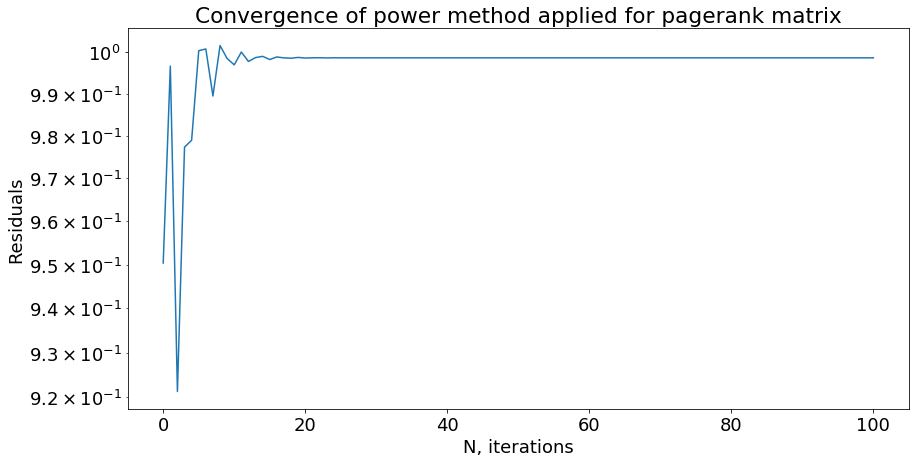

In [205]:
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(res)
plt.title('Convergence of power method applied for pagerank matrix')
plt.ylabel('Residuals')
plt.xlabel('N, iterations')
plt.yscale('log')

plt.show()

In [21]:
print('Eigenvalues of A', np.linalg.eig(A))

Eigenvalues of A (array([-0.5+0.5j, -0.5-0.5j,  1. +0.j ,  1. +0.j , -1. +0.j ]), array([[ 0.35355339+0.35355339j,  0.35355339-0.35355339j,
         0.33333333+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.35355339-0.35355339j,  0.35355339+0.35355339j,
         0.66666667+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [-0.70710678+0.j        , -0.70710678-0.j        ,
         0.66666667+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        ,  0.        -0.j        ,
         0.        +0.j        ,  0.70710678+0.j        ,
        -0.70710678+0.j        ],
       [ 0.        +0.j        ,  0.        -0.j        ,
         0.        +0.j        ,  0.70710678+0.j        ,
         0.70710678+0.j        ]]))


As we discussed on lectures, convergence rate will be $q = \cfrac{|\lambda_2|}{|\lambda_1|}$, which in our case will be exactly 1, since we have eigenvalues equal to $-1$ also. So here we clearly observe absence of convergence

In [22]:
# For changed adjacency matrix
#x0 = np.array([1, 0])
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,1] ]) # New adjacency matrix
A = pagerank_matrix(G)
x0 = np.random.randn(A.shape[0])
x, l, res = power_method(A, x0, num_iter)

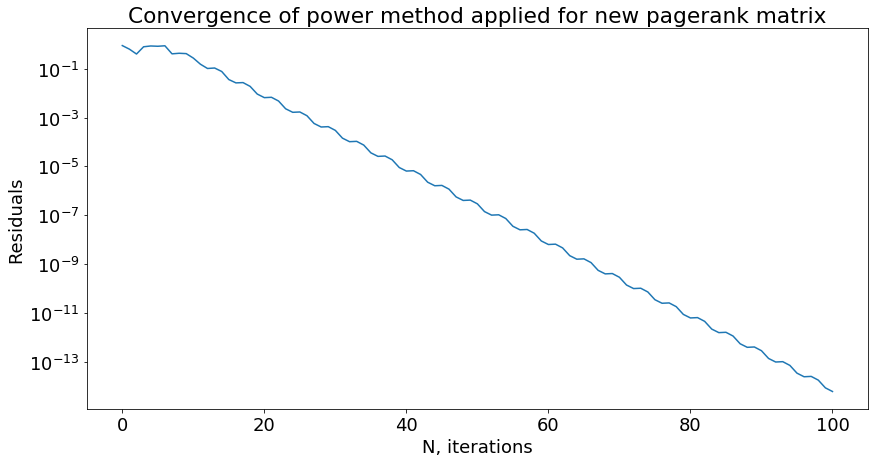

In [23]:
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(res)
plt.title('Convergence of power method applied for new pagerank matrix')
plt.ylabel('Residuals')
plt.xlabel('N, iterations')
plt.yscale('log')

plt.show()

In [24]:
print('Eigenvalues of A', np.linalg.eig(A))

Eigenvalues of A (array([-0.5+0.5j, -0.5-0.5j,  1. +0.j , -0.5+0.j ,  1. +0.j ]), array([[ 0.35355339+0.35355339j,  0.35355339-0.35355339j,
         0.33333333+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.35355339-0.35355339j,  0.35355339+0.35355339j,
         0.66666667+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [-0.70710678+0.j        , -0.70710678-0.j        ,
         0.66666667+0.j        ,  0.        +0.j        ,
         0.        +0.j        ],
       [ 0.        +0.j        ,  0.        -0.j        ,
         0.        +0.j        , -0.70710678+0.j        ,
        -0.4472136 +0.j        ],
       [ 0.        +0.j        ,  0.        -0.j        ,
         0.        +0.j        ,  0.70710678+0.j        ,
        -0.89442719+0.j        ]]))


With new matrix convergence is signifcantly better since in new matrix we will have different set of eigenvalues (to be specific - without $-1$) and the second largest eigenvalue is not close to first.

For eigenvalue l = 1.0000, eigenvector: [-0.3325 -0.6649 -0.6649 -0.0325 -0.0651] , iteration = 0 

For eigenvalue l = 1.0000, eigenvector: [-0.1813 -0.3627 -0.3627 -0.3753 -0.7505] , iteration = 1 

For eigenvalue l = 1.0000, eigenvector: [ 0.3234  0.6469  0.6469 -0.1082 -0.2163] , iteration = 2 

For eigenvalue l = 1.0000, eigenvector: [ 0.1735  0.3471  0.3471 -0.3818 -0.7636] , iteration = 3 

For eigenvalue l = 1.0000, eigenvector: [-0.1422 -0.2844 -0.2844 -0.4045 -0.8089] , iteration = 4 

For eigenvalue l = 1.0000, eigenvector: [-0.2418 -0.4836 -0.4836 -0.3078 -0.6157] , iteration = 5 

For eigenvalue l = 1.0000, eigenvector: [-0.2062 -0.4123 -0.4123  0.3514  0.7028] , iteration = 6 

For eigenvalue l = 1.0000, eigenvector: [0.2779 0.5558 0.5558 0.2469 0.4939] , iteration = 7 

For eigenvalue l = 1.0000, eigenvector: [-0.1115 -0.223  -0.223   0.4214  0.8429] , iteration = 8 

For eigenvalue l = 1.0000, eigenvector: [ 0.1105  0.221   0.221  -0.4219 -0.8438] , iteration = 9 



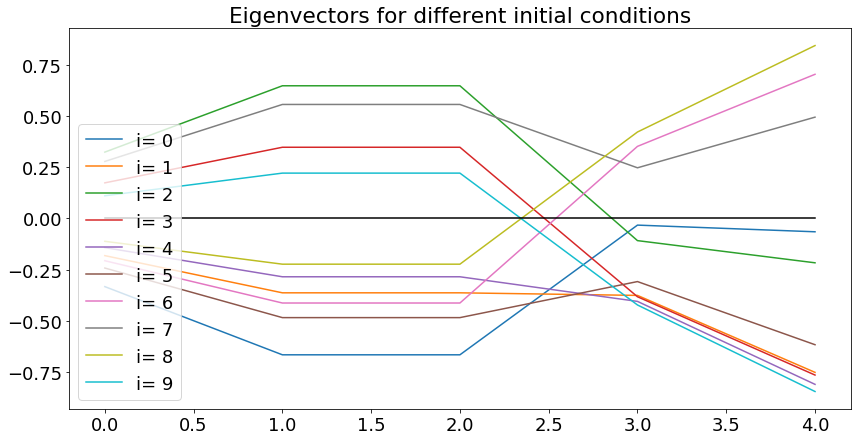

In [25]:
plt.figure(figsize=(14, 7))
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,1] ]) # New adjacency matrix
A = pagerank_matrix(G)
num_iter = 100
np.random.seed(2)
for i in range(10):
    x0 = np.random.randn(A.shape[0])
    x, l, res = power_method(A, x0, num_iter)
    plt.plot(x, label = 'i= %d' % i)
    print('For eigenvalue l = %0.4f, eigenvector:' % l, np.around(x,4), ', iteration = %d' % i, '\n')
plt.plot(range(5), [0]*5, color='black') # y = 0 line to show symmetry   
plt.title('Eigenvectors for different initial conditions')
plt.legend(loc='lower left')
plt.show()

As we can see from picture and data, our eigenvectors are nearly symmetrucaly distributed along x axis (the signum of coordinates only changes - picture inverts). I suggest it happens because we have $2$ equal by modulus eigenvalues (so the multiplicity is 2), so sequence of eigenvectors in our algorithm can can converge to eigenvector corresponding either to one or another eigenvalue (because eigenvector we obtain lies in linear shell, or span / $<...>$, of 2 eigenvectors corresponding our eigenvalues).


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

In [26]:
# Manually constructing Ad matrix:
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,1] ]) # New adjacency matrix
A = pagerank_matrix(G)

d = 0.97
A_d = A*d + (1 - d)/A.shape[0]*np.ones((A.shape[0],A.shape[0]))

x0 = np.random.randn(A_d.shape[0])# For random initial condition
#x0 = np.array([1, 0])
x, l, res = power_method(A_d, x0, num_iter)
print('Largest eigenvalues for random initial condition is ', l)

Largest eigenvalues for random initial condition is  0.9999812435950195


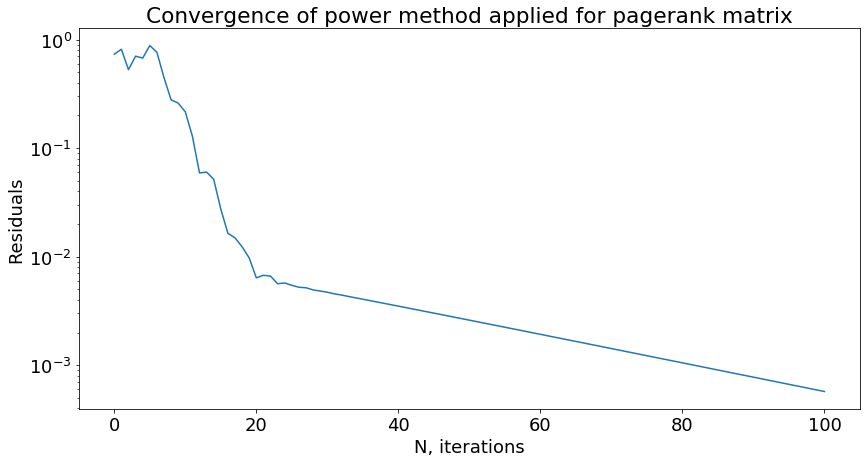

In [27]:
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(res)
plt.title('Convergence of power method applied for pagerank matrix')
plt.ylabel('Residuals')
plt.xlabel('N, iterations')
plt.yscale('log')

plt.show()

In [28]:
# Eig implementation, bit in Piazza we were told not to use buit-in methods, but our own power method with modifications
# So here you can see already outdated solution, in next block I will make proper solution and check it with this one.
lambdas_d, _ = np.linalg.eig(A_d)
print('Largest eigenvalue = %0.2f' % abs(max(lambdas_d)))
list_d = [abs(list(lambdas_d)[i]) for i in range(lambdas_d.shape[0])] # We can just print eigenvalues, but I want it this way
list_d.remove(max(list_d)) # Removing max from newborn list and next max - second in initial array
print('Second largest eigenvalue = %0.2f' % abs(max(list_d)))

Largest eigenvalue = 1.00
Second largest eigenvalue = 0.97


In [29]:
# Let's recall another representation of A: sum[l_i*outer(x_i,x_i)] => our power method is ok for finding 2nd largest eigenvalue:
# now we will find largest eigenvalue for new matrix: A - l_1*outer(x0,x_1), 
# where (l1,x1) - eigenpair of A -> exactly l_2nd_large

#np.random.seed(4)
G = np.array([ [0,1,0,0,0], [0,0,1,0,0], [1,1,0,0,0], [0,0,0,0,1],[0,0,0,1,1] ]) # New adjacency matrix
A = pagerank_matrix(G)
d = 0.97
A_d = A*d + (1 - d)/A.shape[0]*np.ones((A.shape[0],A.shape[0]))
x0 = np.random.randn(A_d.shape[0])# For random initial condition
num_iter = 100

x, l, res = power_method(A_d, x0, num_iter)
print('Largest eigenvalues for random initial condition is ', l)

x2, l2, res2 = power_method(A_d-l*np.outer(x,x), x0, num_iter)
print('Second largest eigenvalues for random initial condition is ', l2)
# Source: https://people.eecs.berkeley.edu/~luca/cs359g/lecture07.pdf - example

Largest eigenvalues for random initial condition is  0.9976165259808281
Second largest eigenvalues for random initial condition is  0.9723207548883941


As we can see, second largest eigenvalue is our parameter d $\Rightarrow$ convergence rate will be $q = \cfrac{|\lambda_2|}{|\lambda_1|} = \cfrac{0.97}{1} = 0.97 < 1$, so the convergence rate comparing to the first experimenе is better. Here also we can see the answer on question about connection of parameter d and convergence rate. Why it is so? There are 2 corresponding theorems that state that: http://www-cs-students.stanford.edu/~taherh/papers/secondeigenvalue.pdf. I suppose it is okay not to retype all of this here.

In [30]:
from scipy.sparse import csr_matrix, random as sp_rnd
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    # enter your code here
    A_csr = csr_matrix(d*A) # creating Compressed Sparse Row matrix from initial A for more efficient storing
    #x_csr = csr_matrix(x)     
    x_csr = csr_matrix(x.reshape((x.shape[0], 1)))  
    #print(A_csr.shape, x_csr.shape)
    '''
    [[1...1],   [x_1     [sum(x_i)
      ...,    *  ...  =   ...
     [1...1]]    x_n]     sum(x_i)], i = 1..n
    
    '''
    x_sum = sum(x)
    #print(np.dot(A_csr, x_csr).shape)
    y =  np.dot(A_csr, x_csr) + (1 - d)/A_csr.shape[0]*x_sum*(np.ones(A.shape[0])).reshape(A.shape[0], 1)
    return np.array(y.T)

#Simple matvec for time profiling
def simple_matvec(A, d, x): # 2 pts
    y =  np.dot(A*d + (1 - d)/A.shape[0]*np.ones((A.shape[0],A.shape[0])), x)
    return np.array(y)

In [31]:
# Creating sparse matrix (density = 10^(-6), because total number of elements 10^8) and self-check using simple_matvec
dim = 10000
d = 0.97
A_sp = sp_rnd(dim, dim, density=1e-6, format='csr',data_rvs=np.ones)
x = np.random.randn(A_sp.shape[0])

#A_sp = csr_matrix(d*A)
#print(A.shape)
#print(A_csr.get_shape()[0])

print(pagerank_matvec(A_sp, d, x))
print(simple_matvec(A_sp, d, x))
# Our programm is correct

[[0.00033842 0.00033842 0.00033842 ... 0.00033842 0.00033842 0.00033842]]
[[0.00033842 0.00033842 0.00033842 ... 0.00033842 0.00033842 0.00033842]]


In [32]:
# Profiling
print("Time for pagerank_matvec for 10 iterations = ", timeit.timeit("pagerank_matvec(A_sp, d, x)", setup="from __main__ import pagerank_matvec, A_sp, d, x", number=10), "s")
print("Time for simple matvec for 10 iterations = ", timeit.timeit("simple_matvec(A_sp, d, x)", setup="from __main__ import simple_matvec, A_sp, d, x", number=10), "s")

Time for pagerank_matvec for 10 iterations =  0.059487799999999424 s
Time for simple matvec for 10 iterations =  15.100573800000006 s


Again, as it was expected, computations with sparse matrices are significantly faster.

Useful sources: 
- https://cmdlinetips.com/2019/02/how-to-create-random-sparse-matrix-of-specific-density/
- https://docs.scipy.org/doc/scipy/reference/sparse.html

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [237]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

In [238]:
# Your code is here
density = G.getnnz()/G.shape[0]/G.shape[0] # Density - number of non-zero elements divided by total number of elements
print("Density of given weighted adjacency matrix is %.1e" % density, '\n')
# Here I found indices of top 10 authors via sorting of dblp_authors.npz (axis=0) and slicing 10 most relevant
print('Top-10 authors: \n',authors[np.argsort(-G.sum(axis=0)[0, :])[0, :10][0, range(10)]].T)
# before G there is minus because we don't want to get least cited authors

Density of given weighted adjacency matrix is 4.5e-05 

Top-10 authors: 
 [['Scott Shenker']
 ['Andrew Zisserman']
 ['Hari Balakrishnan']
 ['Jiawei Han']
 ['Anil K. Jain']
 ['Cordelia Schmid']
 ['Jitendra Malik']
 ['Ion Stoica']
 ['David E. Culler']
 ['David G. Lowe']]


In [239]:
G[G != 0] = 1 # Simple replacing non-zero entries (weights) of G with 1

In [240]:
Page = pagerank_matrix(G) # Creating pagerank matrix Page

In [241]:
# Page_rank matrix is expected to be left-stochastic, so sum of all column elements should be 1 (axis=0)
# But it is not (and in this particular case not even should be), so lets fill 0 columns with 1
print(Page.sum(axis = 0))

[[0. 1. 1. ... 1. 0. 0.]]


Here we can see that some columns are indeed can be summed in $1$, but there are purely 0 columns, that shoulbe also summed to $1$. The standard algorithm suggest to replace zero values with $\frac{1}{N}$, so the sum will be equal $1$ indeed (it is obviously better than creating new edge corresponding to non-existing relation by replacing one of elements of null-column by $1$).

But our matrix is sparse with a lot of zero elements to be changed in order to get left-stochastic matrix. So storing all this $\frac{1}{N}$ elements is not efficient (both in terms of memory and computation) at all to store this numbers in sparse matrix.

In telegram chat there were a suggestion (so yes, the source of this idea - our telegram chat) to store only the indices of such columns and then create an additional term in sum in pagerank_matvec. But instructors in Piazza specifically advised just replace zeros. So we will do:

In [231]:
L=Page.sum(axis=1) # Takes time
for i in range(Page.get_shape()[0]):
    for j in Page.getrow(i).indices:
        Page[i,j] = 1/L[i,0]

In [242]:
from scipy.sparse.linalg import LinearOperator # Suggested linear operator function
L = LinearOperator(Page.shape, matvec=lambda x, A=Page, d=d: pagerank_matvec(A, d, x))

In [243]:
d = 0.85
num_iter = 100
x = np.ones(Page.shape[0])
x_e, l, res_e = power_method(L, x, num_iter)

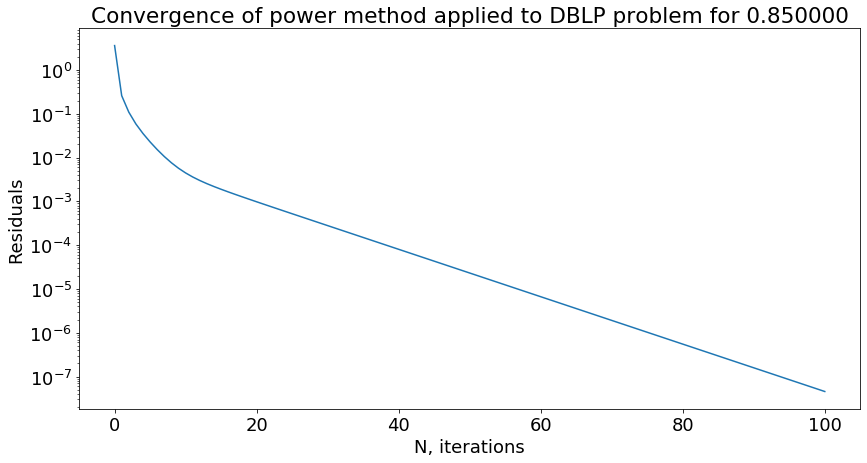

In [258]:
plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 18})
plt.plot(res_e)
plt.title('Convergence of power method applied to DBLP problem for %f' % d)
plt.ylabel('Residuals')
plt.xlabel('N, iterations')
plt.yscale('log')

plt.show()
# Nice descent!

In [259]:
print('Top-10 authors: \n',authors[np.argsort(x_e)[::-1][:10]])  # The information we need is in eigenvectors
# The list completely changed. Possible factors thst affect it - elimination of weights (so this new binary system 
# contains actually less information than old weighted one) and creation of new connections in "zero" columns.

Top-10 authors: 
 ['David E. Goldberg' 'Richard M. Karp' 'John E. Hopcroft'
 'Azriel Rosenfeld' 'Ronald L. Rivest' 'Anil K. Jain' 'Takeo Kanade'
 'Alfred V. Aho' 'Robert Endre Tarjan' 'Gerard Salton']


Useful sources: 
- http://home.ie.cuhk.edu.hk/~wkshum/papers/pagerank.pdf
- https://courses.helsinki.fi/sites/default/files/course-material/4545800/stochastic.pdf
- https://en.wikipedia.org/wiki/Google_matrix (and actually half of links in reference list)